# Divide data into training and validation

In [3]:
from PIL import Image
import glob
import shutil
import os
path_masks = "../input/chest-xray-masks-and-labels/data/Lung Segmentation/masks/"
path_lungs =  "../input/chest-xray-masks-and-labels/data/Lung Segmentation/CXR_png/"
i = 0
for data_type in ["train", "val"]:
    os.makedirs(data_type + "/images",exist_ok=True)
    os.makedirs(data_type + "/masks",exist_ok=True)
for image_path in glob.glob("../input/chest-xray-masks-and-labels/data/Lung Segmentation/CXR_png/*.png"):
    image_name = image_path.split('/')[-1]
    image_mask_path = path_masks + image_name.split('.')[0] + "_mask.png"
    if os.path.exists(image_mask_path):
        if i % 5 == 0:
            shutil.copy(image_mask_path, "val/masks")
            shutil.copy(image_path, "val/images")
        else:
            shutil.copy(image_mask_path, "train/masks")
            shutil.copy(image_path, "train/images")
        i+=1
print(i, "images were copied succesfully ")

566 images were copied succesfully 


# Creating class for loading data

In [4]:
import torch
import torchvision

class LungDataset(torch.utils.data.Dataset):
    def __init__(self,root,transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root, "images", self.imgs[index])
        mask_path = os.path.join(self.root, "masks", self.masks[index])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        if self.transforms is not None:
            img = self.transforms(img)
            mask = self.transforms(mask)
            mask = torch.round(mask)
        return img, mask
    def __len__(self):
        return len(self.imgs)

In [5]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
])

train_dataset = LungDataset('train', train_transforms)
val_dataset = LungDataset('val', train_transforms)

In [6]:
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle = True, num_workers = batch_size)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle = False, num_workers = batch_size)

# Data vizualization

In [7]:
import matplotlib.pyplot as plt
def show_tensorImage(tensorImage, title = ''):
    if tensorImage.shape[0] == 1:
        tensorImage.squeeze_(0)
    else:
        tensorImage = tensorImage.permute(1,2,0)
    image = tensorImage.numpy()
    plt.imshow(image)
    plt.title(title)
    plt.show()
    plt.pause(0.001)

In [6]:
X, Y = next(iter(train_dataloader))

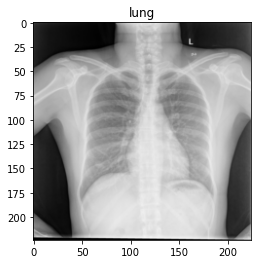

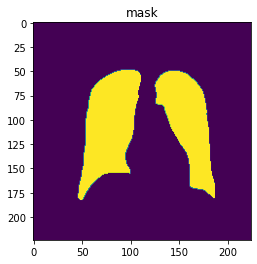

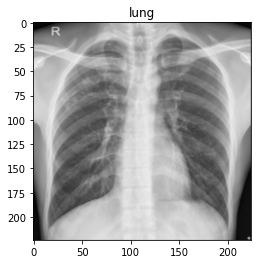

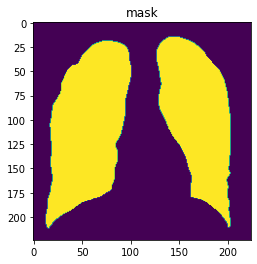

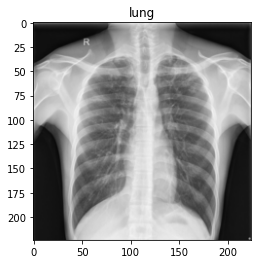

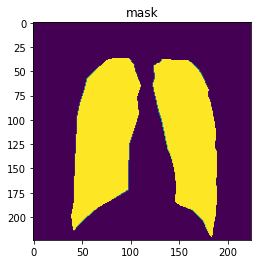

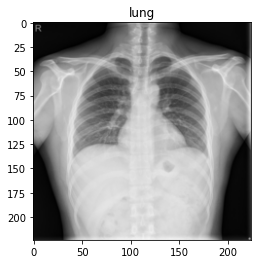

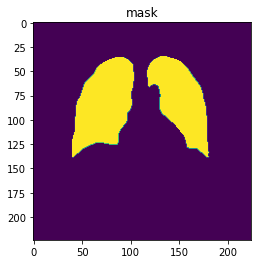

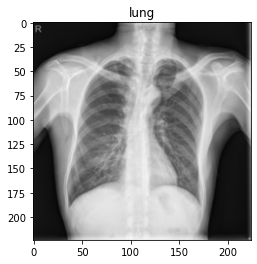

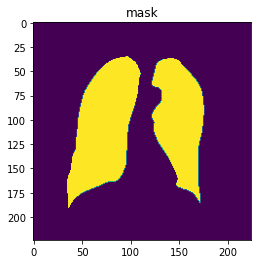

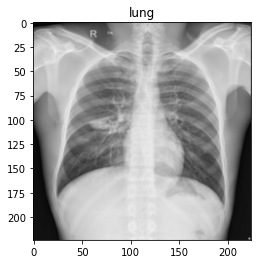

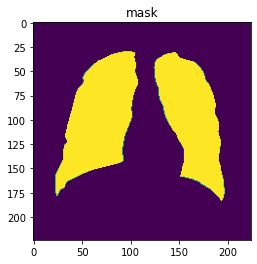

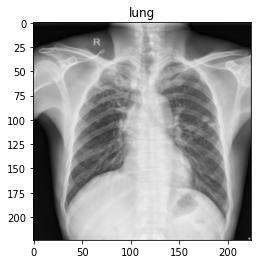

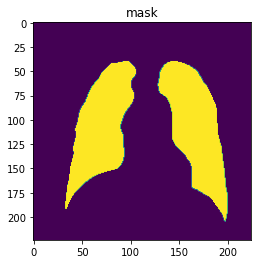

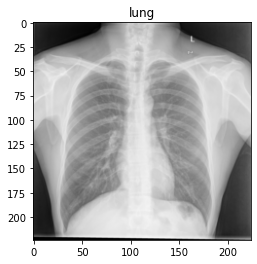

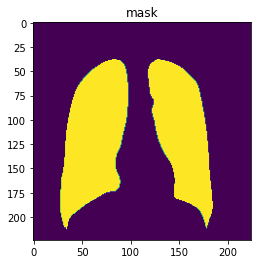

In [7]:
for x, y in zip(X,Y):
    show_tensorImage(x, title='lung')
    show_tensorImage(y, title='mask')

# Creating model

## U-net

In [8]:
class U_Net(torch.nn.Module):
    def __init__(self):
        super(U_Net, self).__init__()
        self.MaxPool = torch.nn.MaxPool2d(kernel_size = (2,2), stride = 2)
        self.UpSample = torch.nn.UpsamplingNearest2d(scale_factor = 2)
        self.downLayer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size = (3,3), stride = 1,padding = (1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size = (3,3), stride = 1,padding = (1,1)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64)
        )
        self.downLayer2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size = (3,3), stride = 1,padding = (1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size = (3,3), stride = 1,padding = (1,1)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128)
        )
        self.downLayer3 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size = (3,3), stride = 1,padding = (1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size = (3,3), stride = 1,padding = (1,1)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(256)
        )
        
        self.downLayer4 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 512, kernel_size = (3,3), stride = 1,padding = (1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, kernel_size = (3,3), stride = 1,padding = (1,1)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(512)
        )
        
        self.upLayer1 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 1024, kernel_size = (3,3), stride = 1, padding = (1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(1024, 1024, kernel_size = (3,3), stride = 1,padding = (1,1)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(1024)
        )
        self.upLayer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1536, 512, kernel_size = (3,3), stride = 1,padding = (1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, kernel_size = (3,3), stride = 1,padding = (1,1)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(512)
        )
        self.upLayer3 = torch.nn.Sequential(
            torch.nn.Conv2d(768, 256, kernel_size = (3,3), stride = 1,padding = (1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size = (3,3), stride = 1,padding = (1,1)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(256)
        )
        self.upLayer4 = torch.nn.Sequential(
            torch.nn.Conv2d(384, 128, kernel_size = (3,3), stride = 1,padding = (1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size = (3,3), stride = 1,padding = (1,1)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128)
        )
        self.upLayer5 = torch.nn.Sequential(
            torch.nn.Conv2d(192, 64, kernel_size = (3,3), stride = 1,padding = (1,1)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size = (3,3), stride = 1,padding = (1,1)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64)
        )
        self.createMask = torch.nn.Conv2d(64,1,kernel_size = (3,3),stride = 1,padding = (1,1))
        self.sigmoid = torch.nn.Sigmoid()
     
    def forward(self, x):
        down_x1 = x
        for layer in self.downLayer1:
            down_x1 = layer(down_x1);
        
        down_x2 = self.MaxPool(down_x1)
        for layer in self.downLayer2:
            down_x2 = layer(down_x2)
        
        down_x3 = self.MaxPool(down_x2)
        for layer in self.downLayer3:
            down_x3 = layer(down_x3)
        
        down_x4 = self.MaxPool(down_x3)
        for layer in self.downLayer4:
            down_x4 = layer(down_x4)
        
        result = self.MaxPool(down_x4)
        for layer in self.upLayer1:
            result = layer(result)
        
        result = self.UpSample(result)
        result = torch.cat((result, down_x4), dim=1)
        for layer in self.upLayer2:
            result = layer(result)
            
        result = self.UpSample(result)
        result = torch.cat((result, down_x3), dim=1)
        for layer in self.upLayer3:
            result = layer(result)
        
        result = self.UpSample(result)
        result = torch.cat((result, down_x2), dim=1)
        for layer in self.upLayer4:
            result = layer(result)
        
        result = self.UpSample(result)
        result = torch.cat((result, down_x1), dim=1)
        for layer in self.upLayer5:
            result = layer(result)
            
        result = self.createMask(result)
        result = self.sigmoid(result)
        return(result)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
u_Net_Model = U_Net()
u_Net_Model = u_Net_Model.to(device)
loss = torch.nn.BCELoss()
optimizer_for_u_Net = torch.optim.Adam(u_Net_Model.parameters(), lr=1.0e-3)

# Training

In [10]:
def train_model(model, num_epochs, loss, optimizer, device):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.

            # Iterate over data.
            for inputs, masks in (dataloader):
                inputs = inputs.to(device)
                masks = masks.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, masks)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()

            epoch_loss = running_loss / len(dataloader)

            print(phase + ' loss = ', epoch_loss)

    return model

In [11]:
train_model(u_Net_Model, 100, loss, optimizer_for_u_Net, device)

Epoch 0/99:
train loss =  0.24728803127481228
val loss =  0.2585926949977875
Epoch 1/99:
train loss =  0.10260214401703131
val loss =  0.08620610584815343
Epoch 2/99:
train loss =  0.08239410039887093
val loss =  0.07301825433969497
Epoch 3/99:
train loss =  0.07454140713078934
val loss =  0.0686961663266023
Epoch 4/99:
train loss =  0.06852879519002479
val loss =  0.07112360845009486
Epoch 5/99:
train loss =  0.062384052757631266
val loss =  0.05818132633964221
Epoch 6/99:
train loss =  0.06508248436607812
val loss =  0.060113129764795305
Epoch 7/99:
train loss =  0.07855640319094323
val loss =  0.29030262927214306
Epoch 8/99:
train loss =  0.06942178119431462
val loss =  0.08790348271528879
Epoch 9/99:
train loss =  0.06402539710203807
val loss =  0.060637317846218744
Epoch 10/99:
train loss =  0.060183145628686534
val loss =  0.06208624045054118
Epoch 11/99:
train loss =  0.05971901131826535
val loss =  0.052035739024480186
Epoch 12/99:
train loss =  0.05768734628432676
val loss =  

KeyboardInterrupt: 

# Result vizualization

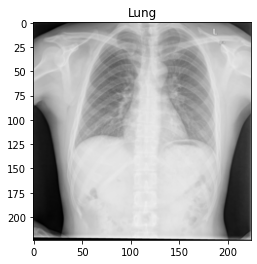

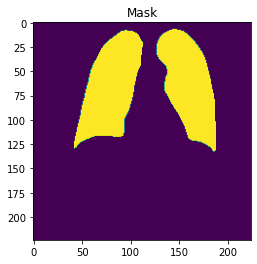

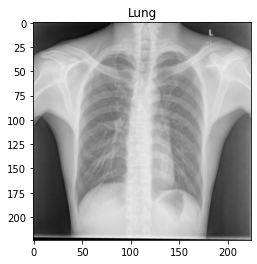

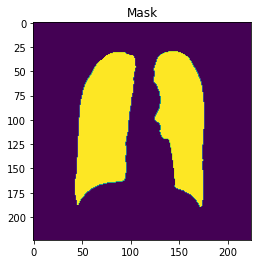

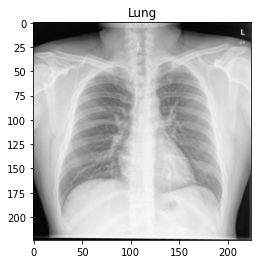

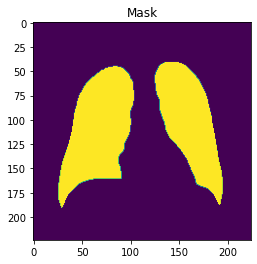

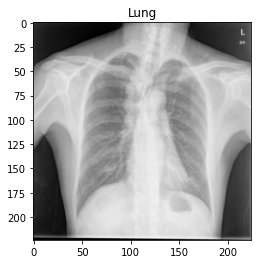

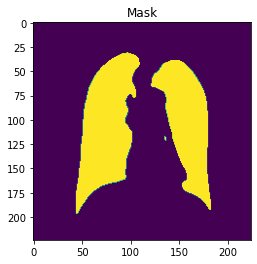

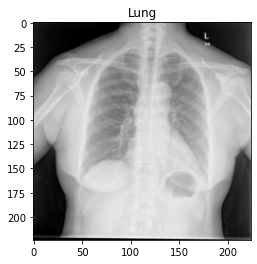

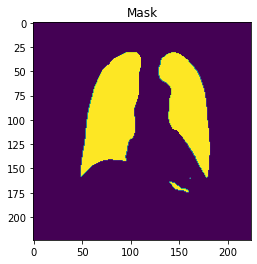

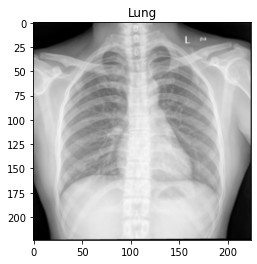

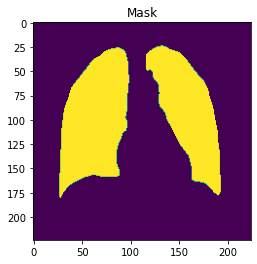

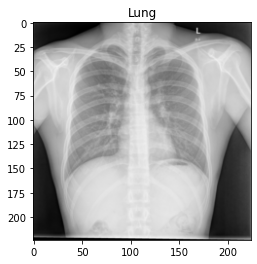

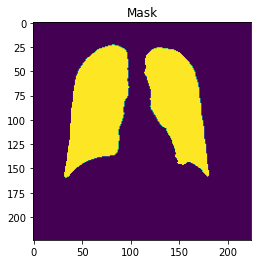

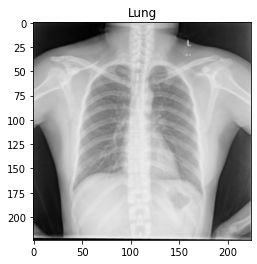

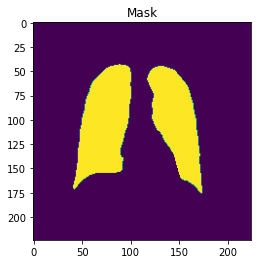

In [16]:
X, Y = next(iter(val_dataloader))
u_Net_Model.eval()
for i in range(8):
    x = X[i]
    pred = u_Net_Model(x.unsqueeze(0).to(device))
    pred = pred.detach()
    show_tensorImage(x,'Lung')
    show_tensorImage(pred.squeeze(0).cpu().round(),'Mask')

# Metrics

In [88]:
def evaluate_iou(y_pred, y_target):
    intersection = torch.sum(y_pred*y_target).item()
    union = torch.sum(y_pred).item() + torch.sum(y_target).item() - intersection
    return intersection/union

In [96]:
u_Net_Model.eval()
iou_value = 0.0
for X,Y in val_dataloader:
    pred = u_Net_Model(X.to(device))
    pred = pred.detach().cpu().round()
    iou_value += evaluate_iou(pred, Y)
iou_value = iou_value/len(val_dataloader)
print('IoU =', iou_value)

IoU = 0.9277147226455614


In [97]:
def evaluate_dice(y_pred, y_target):
    intersection = torch.sum(y_pred*y_target).item()
    union = torch.sum(y_pred).item() + torch.sum(y_target).item()
    return (2*intersection)/union

In [98]:
u_Net_Model.eval()
dice_value = 0.0
for X,Y in val_dataloader:
    pred = u_Net_Model(X.to(device))
    pred = pred.detach().cpu().round()
    dice_value += evaluate_dice(pred, Y)
dice_value = dice_value/len(val_dataloader)
print('Dice =', dice_value)

Dice = 0.962436800683328
